<a href="https://colab.research.google.com/github/cnovak232/DL_Speech_Enhancement/blob/autoencoders/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load Data by cloning the repo - easiest way to access shared data

In [1]:
!git clone https://github.com/cnovak232/DL_Speech_Enhancement.git

Cloning into 'DL_Speech_Enhancement'...
remote: Enumerating objects: 13074, done.
remote: Counting objects: 100% (2394/2394), done.
remote: Compressing objects: 100% (2394/2394), done.
remote: Total 13074 (delta 2), reused 2388 (delta 0), pack-reused 10680
Receiving objects: 100% (13074/13074), 2.71 GiB | 24.68 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Updating files: 100% (13029/13029), done.


Define some helper function for plotting and playing audio

In [2]:
import torch
import torchaudio as ta
import librosa as lib
from IPython.display import Audio, display
import matplotlib
import matplotlib.pyplot as plt

# helper functions for audio and what not
# mostly taken for torchaudio tutorials 

def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
    if num_channels > 1:
        axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
        axes[c].set_xlim(xlim)
    if ylim:
        axes[c].set_ylim(ylim)

    figure.suptitle(title)
    plt.show(block=False)

def get_spectrogram(
    waveform = None,
    n_fft = 512,
    win_len = None,
    hop_len = None,
    power = 1.0 ):
    spectrogram = ta.transforms.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power )
    
    return spectrogram(waveform)

def plot_spectrogram(spec, type = "amplitude", title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    toDb = ta.transforms.AmplitudeToDB(type)
    im = axs.imshow(spec, origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

def norm_spec( spec ):
    normed = spec / spec.max()
    return normed, spec.max()

Define a Custom Dataset class for the Data and read it in

torch.Size([1, 257, 313])
35460


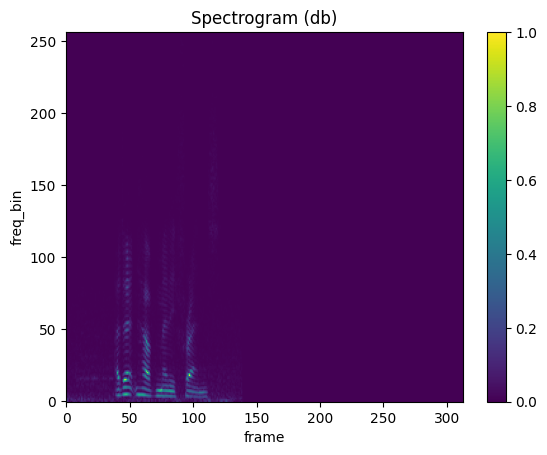

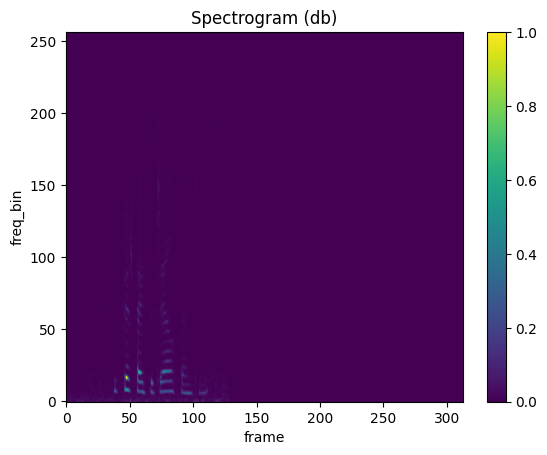

In [4]:
# read dataset in and downsample / transform / pad if needed
from torch.utils.data import Dataset
import torch
import os

class VoiceBankDemand(Dataset):
    def __init__(self, clean_dir, noisy_dir, list_dir, 
                 data = "train", len_samples = None, downsample = None, 
                 transform = None ):
        self.clean_dir = clean_dir
        self.noisy_dir = noisy_dir
        self.list_dir = list_dir
        self.num_samples = len_samples
        self.downsample = downsample
        self.transform = transform
        self.data = data
    
    def __len__(self):
        return len(self.list_dir)

    def __getitem__( self, idx ):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        clean_name = os.path.join( self.clean_dir, self.list_dir[idx] )
        noisy_name = os.path.join( self.noisy_dir, self.list_dir[idx] )
        clean_audio, fs = ta.load(clean_name)
        noisy_audio, fs= ta.load(noisy_name)

        if self.downsample:
            downsampler = ta.transforms.Resample(fs,self.downsample)
            clean_audio = downsampler( clean_audio )
            noisy_audio = downsampler( noisy_audio )

        if self.num_samples:
            orig_len = clean_audio.shape[1]
            if clean_audio.shape[1] > num_samples:
                clean_audio = clean_audio[:,:num_samples]
                noisy_audio = noisy_audio[:,:num_samples]
            elif clean_audio.shape[1] < num_samples:
                pad_len = int( num_samples - clean_audio.shape[1] )
                pad = torch.zeros(1,pad_len)
                clean_audio = torch.cat((clean_audio,pad), dim=1)
                noisy_audio = torch.cat((noisy_audio,pad),dim=1)
        
        if self.data == "test":
            if self.transform:
                noisy_trnsfrm = self.transform( noisy_audio )
                clean_trnsfrm = self.transform( clean_audio )
            clean_mag,_ = norm_spec( torch.abs(clean_trnsfrm) )
            clean_audio = (clean_audio, clean_mag)
            noisy_mag, norm_val = norm_spec( torch.abs(noisy_trnsfrm) )
            noisy_phase = torch.angle(noisy_trnsfrm)
            noisy_audio = (noisy_mag, noisy_phase, noisy_audio, norm_val)
        else:
            if self.transform:
                clean_audio,_ = norm_spec( self.transform( clean_audio ) )
                noisy_audio,_ = norm_spec( self.transform( noisy_audio ) )

        sample = (clean_audio, noisy_audio, orig_len)

        return sample

train_clean_path = './DL_Speech_Enhancement/clean_trainset_28spk_wav'
train_noisy_path = './DL_Speech_Enhancement/noisy_trainset_28spk_wav'
test_clean_path  = './DL_Speech_Enhancement/clean_testset_wav'
test_noisy_path  = './DL_Speech_Enhancement/noisy_testset_wav'

list_dir_train = os.listdir(train_clean_path)
list_dir_test = os.listdir(test_clean_path)

target_fs = 16000 # downsample to 16 KHz
spectrogram = ta.transforms.Spectrogram(
    n_fft=512,
    power=1.0,
    normalized = False )
complex_spec = ta.transforms.Spectrogram(
    n_fft=512,
    power=None,
    normalized = False ) # return complex spectrum

num_samples = int( 5.0 * target_fs ) 

train_set = VoiceBankDemand( clean_dir = train_clean_path,
                             noisy_dir = train_noisy_path,
                             list_dir = list_dir_train,
                             len_samples = num_samples, # clip or pad samples to be 5s
                             downsample = target_fs, # downsample to 16Khz
                             transform = spectrogram )

# returns the mag/phase of each audio file 
test_set = VoiceBankDemand( clean_dir = test_clean_path,
                            noisy_dir = test_noisy_path,
                            list_dir = list_dir_test,
                            data = "test",
                            len_samples = num_samples,
                            downsample = target_fs,
                            transform = complex_spec )


clean, noisy, orig_len = train_set[1]
print(clean.size())
print(orig_len)

clean_test, noisy_test, orig_len = test_set[0]

noisy_mag, noisy_phase, noisy_audio, norm_val = noisy_test

plot_spectrogram(noisy.squeeze())
plot_spectrogram(noisy_mag.squeeze())